In [1]:
!pip install fastai

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     |████████████████████████████████| 233 kB 66.8 MB/s eta 0:00:01
     |████████████████████████████████| 6.5 MB 69.0 MB/s eta 0:00:01
     |████████████████████████████████| 67 kB 60.1 MB/s eta 0:00:01
     |████████████████████████████████| 56 kB 55.8 MB/s eta 0:00:01
     |████████████████████████████████| 3.1 MB 68.2 MB/s eta 0:00:01
     |████████████████████████████████| 48 kB 58.2 MB/s eta 0:00:01
     |████████████████████████████████| 490 kB 71.7 MB/s eta 0:00:01
     |████████████████████████████████| 181 kB 74.7 MB/s eta 0:00:01
     |████████████████████████████████| 914 kB 70.9 MB/s eta 0:00:01
     |████████████████████████████████| 126 kB 70.2 MB/s eta 0:00:01
     |████████████████████████████████| 10.2 MB 69.5 MB/s eta 0:00:01
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.0.1
    Uninstalling typing-extensions-4.0.1:
      Successfully uninstalled typing-ext

In [2]:
!pip install split-folders

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


In [3]:
# 上传自己构建好的数据集
!featurize dataset download 87b8edc9-8245-47bd-b79d-4731e4c9d8d8

100%|██████████████████████████████████████| 67.2M/67.2M [00:00<00:00, 491MiB/s]
🍬  下载完成，正在解压...
🏁  数据集已经成功添加


# +5

In [4]:
# 划分图像文件夹为训练集、验证集和测试集，要求: seed=1337, ratio=(0.6, 0.2, 0.2)  
import splitfolders
splitfolders.ratio(input='data/dog images/images', output='images', seed=1337, ratio=(0.6, 0.2, 0.2))

Copying files: 1857 files [00:00, 5921.77 files/s]


In [5]:
from fastai.vision.all import *

In [6]:
# 准备数据集
path = Path("images")

In [7]:
# 图片大小统一化处理
item_tfms = Resize(224)

In [8]:
# 数据增强
batch_tfms = aug_transforms()

In [9]:
# 创建DataLoaders
dls = ImageDataLoaders.from_folder(
    path,
    train = 'train',
    valid = 'val',
    seed = 42,
    item_tfms = item_tfms,
    batch_tfms = batch_tfms,
    bs = 32)

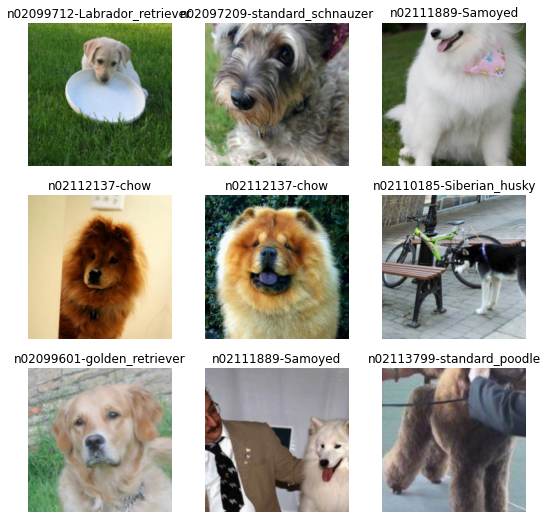

In [10]:
dls.show_batch()

In [11]:
arch = resnet18

In [12]:
# 创建一个CNN学习器
learn1 = vision_learner(dls, arch, metrics=accuracy)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/featurize/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [13]:
# 使用fastai库中的EarlyStoppingCallback和SaveModelCallback来改进模型训练过程
from fastai.callback.tracker import EarlyStoppingCallback, SaveModelCallback

In [14]:
early_stop_cb = EarlyStoppingCallback

save_model_cb =  SaveModelCallback()

In [15]:
learn1.fine_tune(20, 3e-3,cbs=[early_stop_cb,save_model_cb])

epoch,train_loss,valid_loss,accuracy,time
0,1.367984,0.157177,0.953804,00:03


Better model found at epoch 0 with valid_loss value: 0.1571771651506424.


epoch,train_loss,valid_loss,accuracy,time
0,0.307920,0.135809,0.959239,00:04
1,0.238684,0.124401,0.964674,00:04
2,0.166988,0.097739,0.970109,00:04
3,0.143568,0.164526,0.948370,00:04


Better model found at epoch 0 with valid_loss value: 0.13580884039402008.
Better model found at epoch 1 with valid_loss value: 0.12440115213394165.
Better model found at epoch 2 with valid_loss value: 0.09773897379636765.
No improvement since epoch 2: early stopping


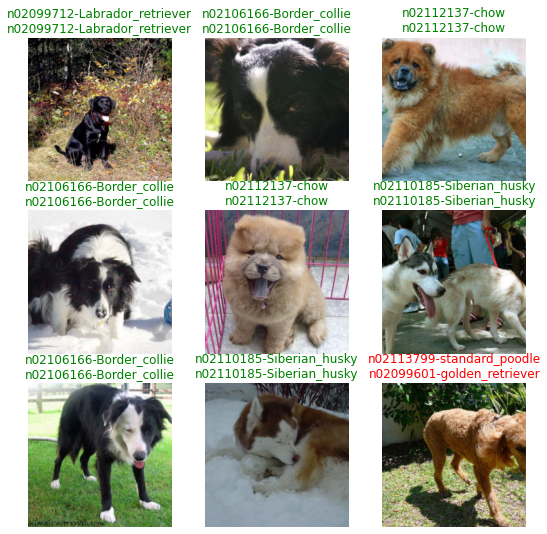

In [16]:
learn1.show_results()

In [17]:
# Create the interpretation object using the from_learner method
#使用from_learner方法创建解释对象
interp = ClassificationInterpretation.from_learner(learn1)

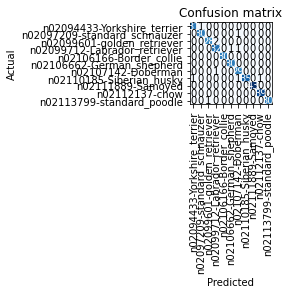

In [18]:
# Plot the confusion matrix
#绘制混淆矩阵
interp.plot_confusion_matrix()

In [19]:
# Show per-class metrics (e.g., precision, recall, F1-score)
#显示每类指标（例如，精确度、召回率、F1分数）
interp.print_classification_report()

                              precision    recall  f1-score   support

 n02094433-Yorkshire_terrier       0.97      0.97      0.97        32
n02097209-standard_schnauzer       0.97      0.97      0.97        31
  n02099601-golden_retriever       0.97      0.93      0.95        30
n02099712-Labrador_retriever       0.91      0.94      0.93        34
     n02106166-Border_collie       1.00      1.00      1.00        30
   n02106662-German_shepherd       0.97      1.00      0.98        30
          n02107142-Doberman       0.91      0.97      0.94        30
    n02110185-Siberian_husky       1.00      0.92      0.96        38
           n02111889-Samoyed       1.00      1.00      1.00        43
              n02112137-chow       0.97      1.00      0.99        39
   n02113799-standard_poodle       1.00      0.97      0.98        31

                    accuracy                           0.97       368
                   macro avg       0.97      0.97      0.97       368
                we

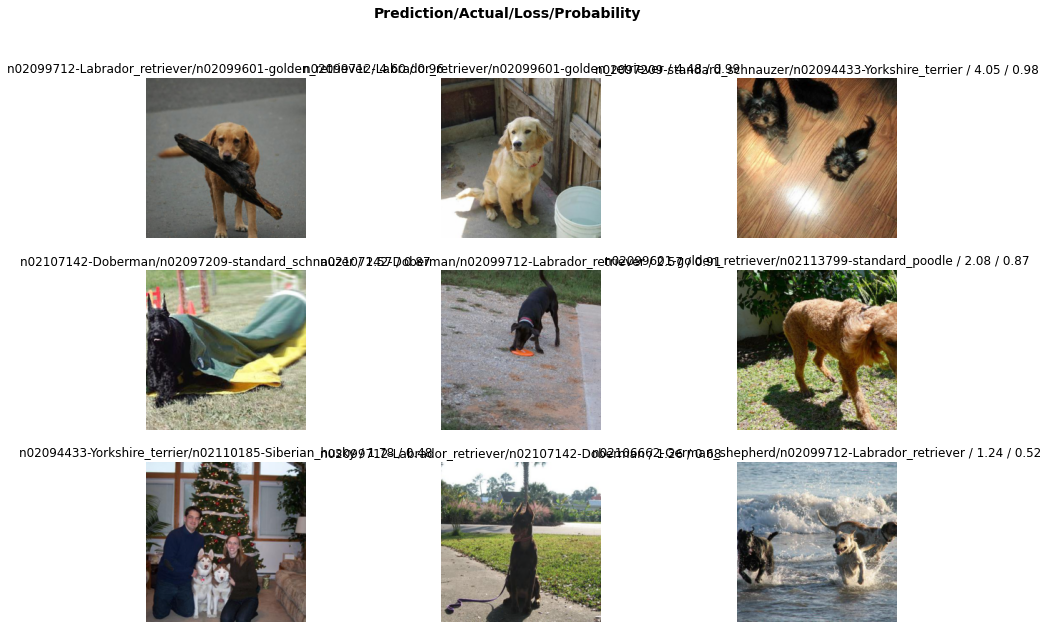

In [20]:
# 打印出预测错误率最高的9张图片
interp.plot_top_losses(9, figsize=(15,10))

# +10

In [21]:
# 创建测试集上的DataLoaders
test_dl = dls.test_dl(get_image_files(path/'test'),
                      with_labels=True)

In [22]:
preds, targets = learn1.get_preds(dl=test_dl)

# preds

In [23]:
from fastai.tabular.all import *

In [24]:
accuracy(preds, targets)

TensorBase(0.9709)

In [25]:
# Create the interpretation object of test_dl using the from_learner method
interp = ClassificationInterpretation.from_learner(learn1, 
                                                   dl=test_dl)

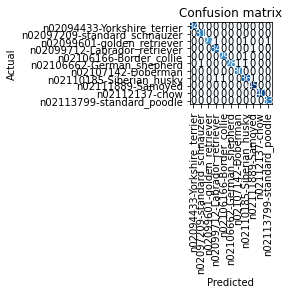

In [26]:
# Plot the confusion matrix
interp.plot_confusion_matrix()

In [27]:
# Show per-class metrics (e.g., precision, recall, F1-score)
interp.print_classification_report()

                              precision    recall  f1-score   support

 n02094433-Yorkshire_terrier       1.00      1.00      1.00        34
n02097209-standard_schnauzer       0.97      1.00      0.98        31
  n02099601-golden_retriever       1.00      0.90      0.95        30
n02099712-Labrador_retriever       0.94      0.97      0.96        35
     n02106166-Border_collie       0.97      0.97      0.97        30
   n02106662-German_shepherd       1.00      0.90      0.95        31
          n02107142-Doberman       0.97      1.00      0.98        30
    n02110185-Siberian_husky       0.92      0.92      0.92        39
           n02111889-Samoyed       0.96      1.00      0.98        45
              n02112137-chow       1.00      1.00      1.00        40
   n02113799-standard_poodle       0.97      1.00      0.99        33

                    accuracy                           0.97       378
                   macro avg       0.97      0.97      0.97       378
                we

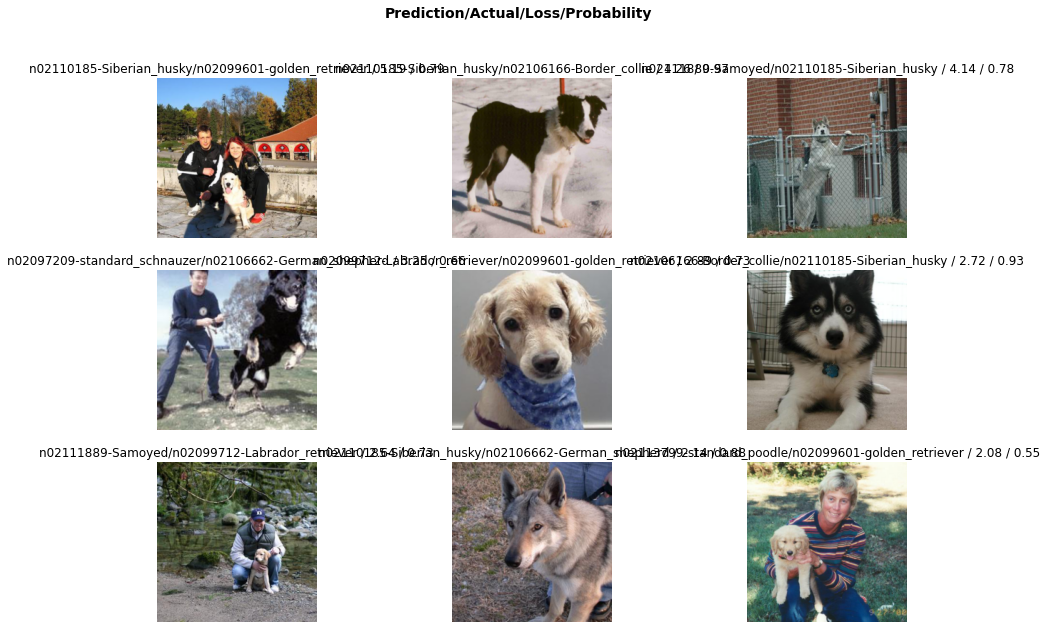

In [28]:
# 打印测试集中出预测错误率最高的9张图片
interp.plot_top_losses(9, figsize=(15,10))

# +5

In [29]:
# Grad-CAM
import fastai.vision.all as fv
import matplotlib.pyplot as plt
import cv2
import torch

def grad_cam(learn, img_path, layer_name=None):
    img = fv.PILImage.create(img_path)
    x = fv.tensor(img).float() / 255.
    x = x.permute(2, 0, 1)  # Rearrange dimensions to (channels, height, width)  将尺寸重新排列为（渠道、高度、宽度）
    xb = x.unsqueeze(0).cuda()
    learn.model.eval()

    if layer_name is None:
        layer_name = learn.model[0][-2]

    hook_output = []
    hook = fv.hook_output(layer_name)

    output = learn.model(xb)
    preds = torch.softmax(output, dim=1)
    class_idx = preds.argmax(dim=1).item()

    one_hot = torch.zeros_like(output)
    one_hot[0, class_idx] = 1.0

    # Clear gradients before backward pass
    #向后传球前清除坡度
    learn.model.zero_grad()

    # Perform backward pass with one_hot tensor as the gradient
    #使用one_hot张量作为梯度执行反向传递
    output.backward(gradient=one_hot)

    grads = hook.stored[0]
    weights = grads.mean(dim=[1, 2], keepdim=True)
    cam_map = (weights * hook.stored[0]).sum(dim=0)
    cam_map = torch.relu(cam_map).cpu().detach().numpy()


    # Normalize the CAM map
    #规范化CAM映射
    cam_map = (cam_map - cam_map.min()) / (cam_map.max() - cam_map.min())

    # Resize the CAM map to the original image size and apply a colormap
    #将CAM贴图调整为原始图像大小并应用颜色贴图
    cam_map_resized = cv2.resize(cam_map, (img.width, img.height))
    heatmap = cv2.applyColorMap((cam_map_resized * 255).astype('uint8'), cv2.COLORMAP_JET)

    # Superimpose the heatmap on the original image with an opacity of 0.5
    #将热图叠加在不透明度为0.5的原始图像上
    result = cv2.addWeighted(np.array(img), 0.5, heatmap, 0.5, 0)

    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title('Original Image')
    plt.subplot(1, 2, 2)
    plt.imshow(img)
    plt.imshow(cam_map, alpha=0.5, cmap='jet', interpolation='bilinear', vmin=0, vmax=1)
    plt.axis('off')
    plt.title(learn.dls.vocab[class_idx])
    plt.show()

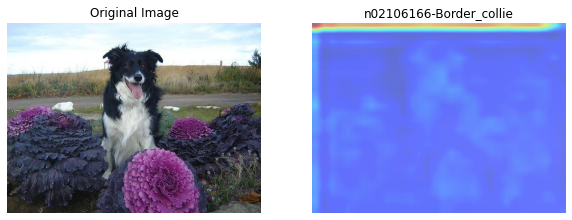

In [30]:
# Use the function with the path to an image file
grad_cam(learn1, "images/train/n02106166-Border_collie/n02106166_1244.jpg")

In [31]:
def grad_cam_on_original(learn, img_path, layer_name=None):
    img = fv.PILImage.create(img_path)
    x = fv.tensor(img).float() / 255.
    x = x.permute(2, 0, 1)  # Rearrange dimensions to (channels, height, width) 将尺寸重新排列为（渠道、高度、宽度）
    xb = x.unsqueeze(0).cuda()
    learn.model.eval()

    if layer_name is None:
        layer_name = learn.model[0][-2]

    hook_output = []
    hook = fv.hook_output(layer_name)

    output = learn.model(xb)
    preds = torch.softmax(output, dim=1)
    class_idx = preds.argmax(dim=1).item()

    one_hot = torch.zeros_like(output)
    one_hot[0, class_idx] = 1.0

    # Clear gradients before backward pass
    #向后传球前清除坡度
    learn.model.zero_grad()

    # Perform backward pass with one_hot tensor as the gradient
    #使用one_hot张量作为梯度执行反向传递
    output.backward(gradient=one_hot)

    grads = hook.stored[0]
    weights = grads.mean(dim=[1, 2], keepdim=True)
    cam_map = (weights * hook.stored[0]).sum(dim=0)
    cam_map = torch.relu(cam_map).cpu().detach().numpy()


    # Normalize the CAM map
    #规范化CAM映射
    cam_map = (cam_map - cam_map.min()) / (cam_map.max() - cam_map.min())

    # Resize CAM to the size of the original image
    #将CAM调整为原始图像的大小
    cam_resized = cv2.resize(cam_map, (img.width, img.height), interpolation=cv2.INTER_LINEAR)

    # Normalize CAM between 0 and 1
    #规格化0和1之间的CAM
    cam_resized = (cam_resized - cam_resized.min()) / (cam_resized.max() - cam_resized.min())

    # Convert the original image to BGR format (as required by OpenCV)
    #将原始图像转换为BGR格式（根据OpenCV的要求）
    img_bgr = np.array(img)[:, :, ::-1]

    # Apply colormap to the CAM
    #将颜色映射应用于CAM
    heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)

    # Blend the original image with the heatmap
    #将原始图像与热图混合
    blended_image = cv2.addWeighted(img_bgr, 0.7, heatmap, 0.3, 0)

    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title('Original Image')
    plt.subplot(1, 2, 2)
    plt.imshow(blended_image[:, :, ::-1])  # Convert back to RGB format for displaying with Matplotlib 转换回RGB格式以与Matplotlib一起显示
    plt.axis('off')
    plt.title(learn.dls.vocab[class_idx])
    plt.show()

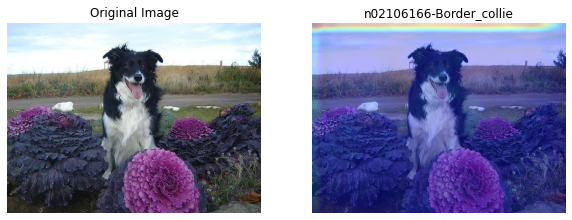

In [32]:
# Use the function with the path to an image file
grad_cam_on_original(learn1, "images/train/n02106166-Border_collie/n02106166_1244.jpg")

In [33]:
# install torchcam（用于做热力图）
!pip install torchcam

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


In [34]:
from torchvision.io.image import read_image
from torchvision.transforms.functional import normalize, resize, to_pil_image
from torchvision.models import resnet18
from torchcam.methods import SmoothGradCAMpp

# model = learn.model.eval()
model = resnet18(pretrained=True).eval()

In [35]:
# Get your input
img = read_image( "images/train/n02106166-Border_collie/n02106166_1244.jpg")

In [36]:
# Preprocess it for your chosen model
input_tensor = normalize(resize(img, (224, 224)) / 255., [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
# Enable gradients for the input tensor
# input_tensor.requires_grad = True
# Create a SmoothGradCAMpp instance without using 'with' statement
cam_extractor = SmoothGradCAMpp(model)

# Preprocess your data and feed it to the model
out = model(input_tensor.unsqueeze(0))
# Retrieve the CAM by passing the class index and the model output
activation_map = cam_extractor(out.squeeze(0).argmax().item(), out)

# # Don't forget to clean up the hooks after using the cam_extractor
# cam_extractor.clear_hooks()

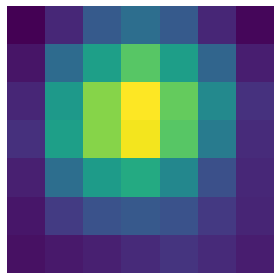

In [37]:
import matplotlib.pyplot as plt
# Visualize the raw CAM
#可视化原始CAM
plt.imshow(activation_map[0].squeeze(0).numpy()); plt.axis('off'); plt.tight_layout(); plt.show()

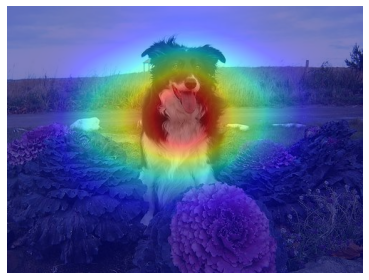

In [38]:
import matplotlib.pyplot as plt
from torchcam.utils import overlay_mask

# Resize the CAM and overlay it
#调整CAM的大小并覆盖它
result = overlay_mask(to_pil_image(img), to_pil_image(activation_map[0].squeeze(0), mode='F'), alpha=0.5)
# Display it
#显示它
plt.imshow(result); plt.axis('off'); plt.tight_layout(); plt.show()

In [39]:
learn1.export(fname='export_1.pkl')